We start by loading the `pacman` and `rio` packages, enabling us to import data on SPY in the form of a .csv file.

In [2]:
install.packages('pacman')

Installing package into 'C:/Users/admin/AppData/Local/R/win-library/4.2'
(as 'lib' is unspecified)



package 'pacman' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\admin\AppData\Local\Temp\RtmpAHjsCJ\downloaded_packages


In [4]:
pacman::p_load(pacman, rio) 
spy_2yr <- import("df_daily_2yr.csv")

## Stationarity

Autoregressive models are typically restricted to data that is considered “stationary”. Data that is stationary does not exhibit trends or seasonality; instead, like white noise, observations taken at different times should look similar, without displaying predictable patterns over the long-term.

We examine the closing price of SPY over the last two years, ranging from September 4, 2020 to September 2, 2022. This time series is referred to herein as “SPY”. At first glance, a plot of this data exhibits a strong upward trend in approximately the first 60% the data, and cyclical variation in the following portion.  

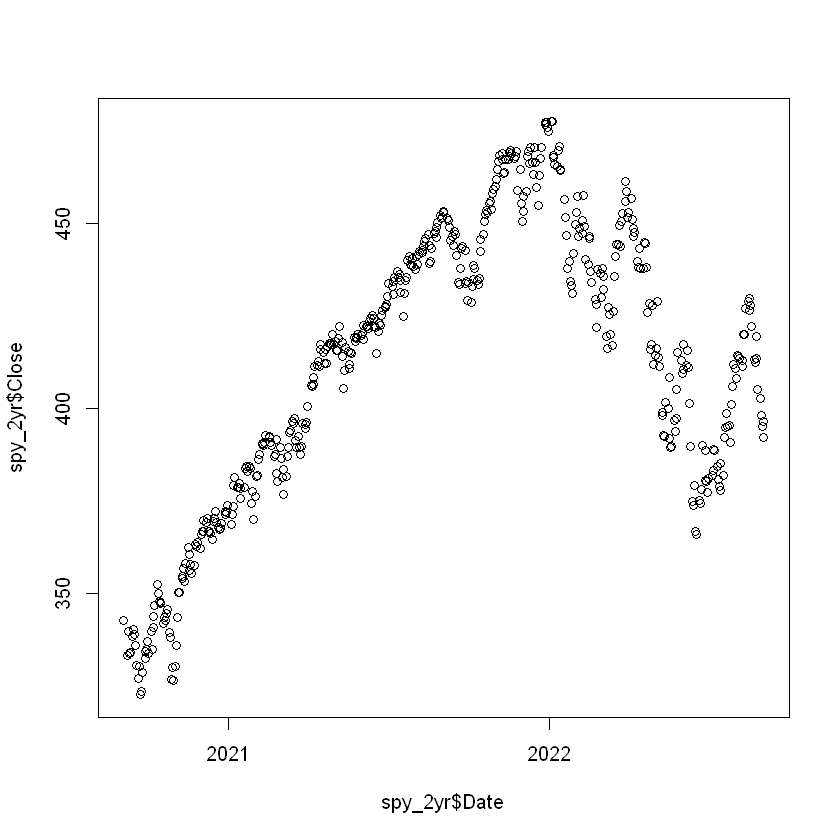

In [6]:
plot(spy_2yr$Date, spy_2yr$Close)

Autocorrelation function (ACF) plots provide one useful mechanism for identifying a non-stationary time series, which visualize autocorrelations in data at increasing time lags. The ACF plot of SPY shows smoothly and monotonically decreasing autocorrelations, which are indicative of a non-stationary series. 

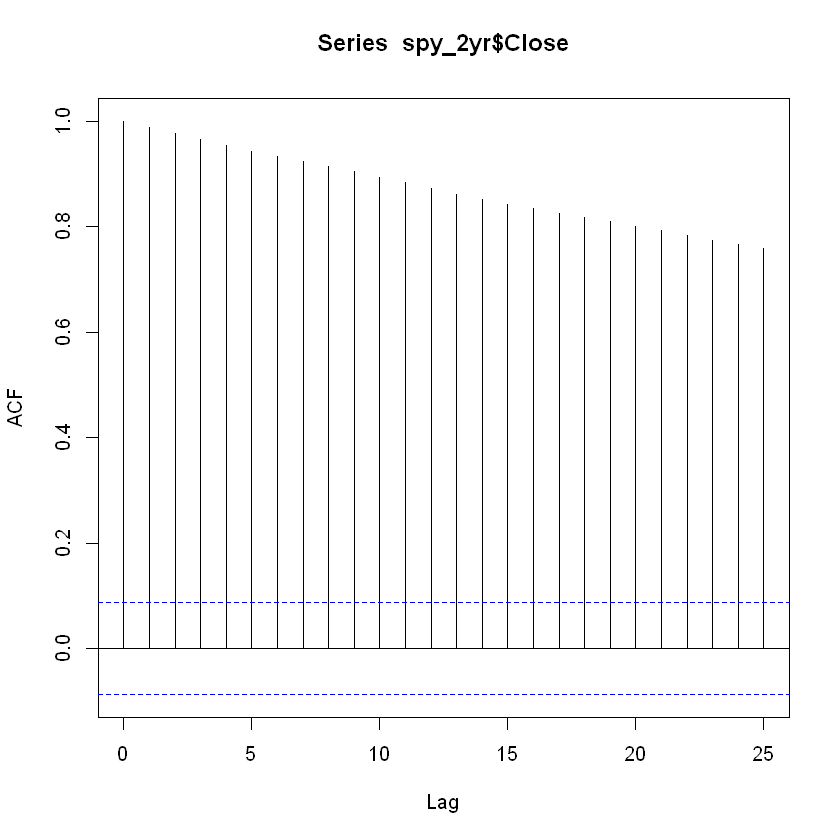

In [7]:
acf(spy_2yr$Close, lag.max = 25, plot = TRUE)

The Ljung-Box test provides a useful mechanism for determining whether a group of autocorrelations in a time series are different from zero. 

In [8]:
Box.test(spy_2yr$Close, lag=10, type="Ljung-Box")


	Box-Ljung test

data:  spy_2yr$Close
X-squared = 4514.4, df = 10, p-value < 2.2e-16


For 10 time lags, this test gives a p-value of 2.2e-16. We thus reject the null hypothesis (that the time series is random) and conclude that the time series is not random or white noise.

## Differencing
Differencing is typically the first remedy to render a time series stationary, which consists of subtracting, from every observation (with the exception of the very first observation), the prior observation. 

A plot of the differenced time series of SPY appears largely random and noisy. The ACF plot of the differenced time series does not appear to show spikes that are statistically significant.

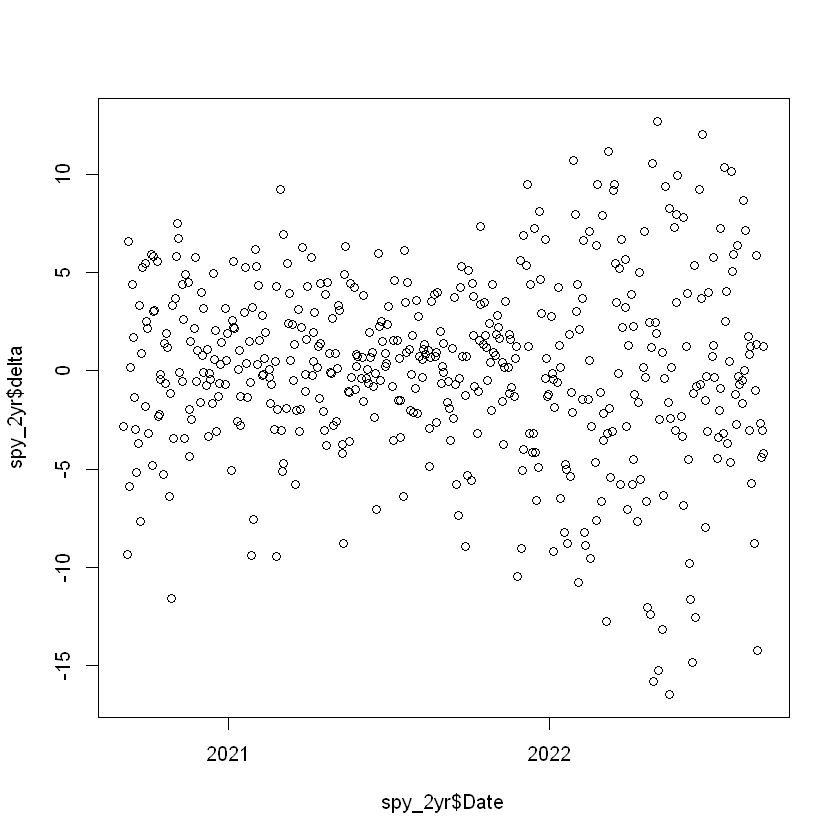

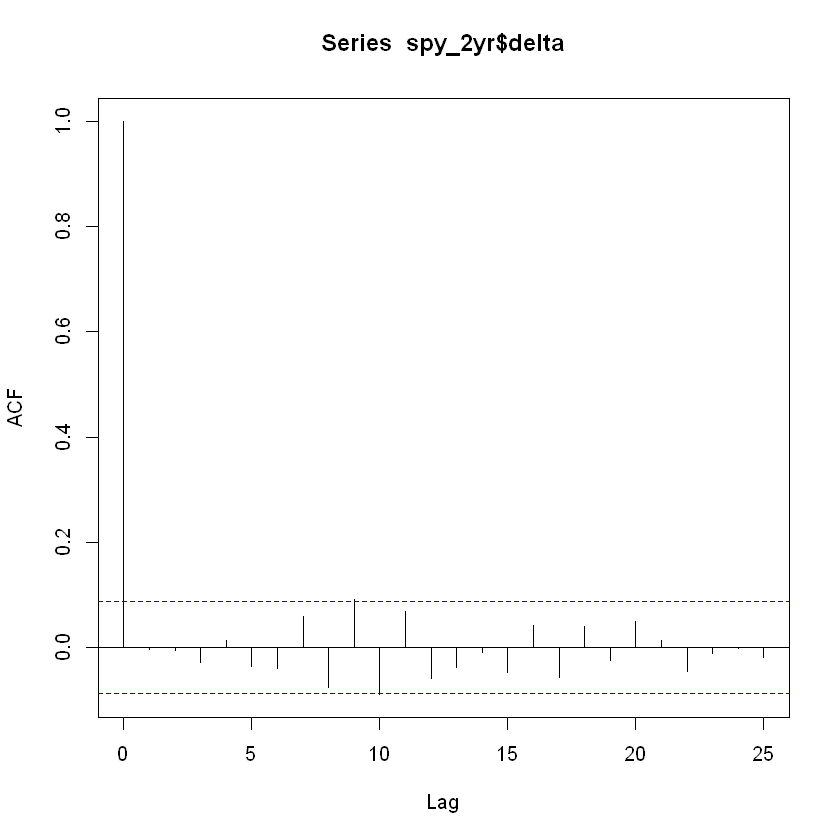

In [9]:
plot(spy_2yr$Date, spy_2yr$delta)
acf(spy_2yr$delta, lag.max = 25, plot = TRUE)

The Ljung-Box test gives a p-value of 0.119 for the differenced SPY series. For a 5% significance level, we fail to reject the null hypothesis and conclude that the differenced series does not exhibit significant autocorrelations. 

In [10]:
Box.test(spy_2yr$delta, lag=10, type="Ljung-Box")


	Box-Ljung test

data:  spy_2yr$delta
X-squared = 15.375, df = 10, p-value = 0.119


A more objective test of whether differencing is required for stationarity is a unit root test such as the Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test, in which the null hypothesis is that the series is stationary. This gives a test statistic of 0.2822, lower than any of the given critical values, suggesting the differenced series is stationary. 

In [11]:
pacman::p_load(urca)
ur.kpss(spy_2yr$delta)


####################################### 
# KPSS Unit Root / Cointegration Test # 
####################################### 

The value of the test statistic is: 0.2822 


Applying the function `ndiffs()` to the original non-differenced series suggests a single first difference should be applied to obtain stationarity. 

In [12]:
pacman::p_load(forecast)
ndiffs(spy_2yr$Close)

[1] 1

<b>Given the above, we conclude that applying a first difference to SPY should be sufficient to produce a stationary time series. We can now employ forecasting techniques that apply to stationary time series, such as ARIMA.</b>

## Manually fitting ARIMA models
While R makes it easy to automatically fit ARIMA models, we consider a few criteria that inform the selection of specific ARIMA models. Selecting a specific ARIMA model consists of choosing (p) the order of the autoregressive portion of an ARIMA model, (d) the extent of differencing applied to the time series, and (q) the order of the moving average portion of the ARIMA model. These parameters are often used to summarize an ARIMA model in the form ARIMA(p, d, q).

We can examine ACF and partial autocorrelation function (PACF) plots of the differenced SPY time series to get a sense of what type of ARIMA model may apply. 

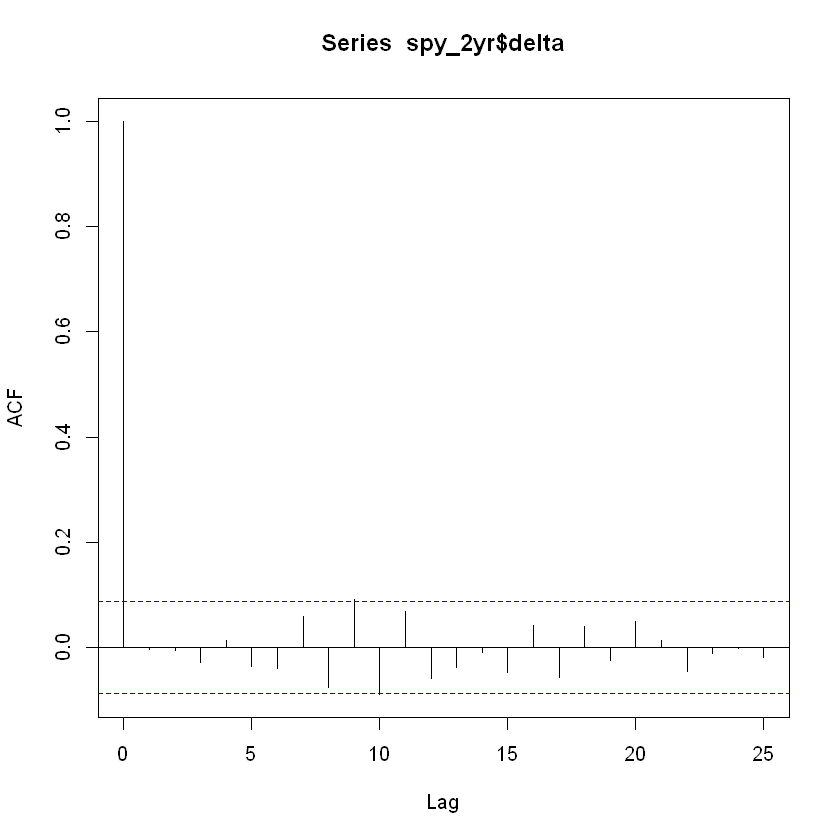

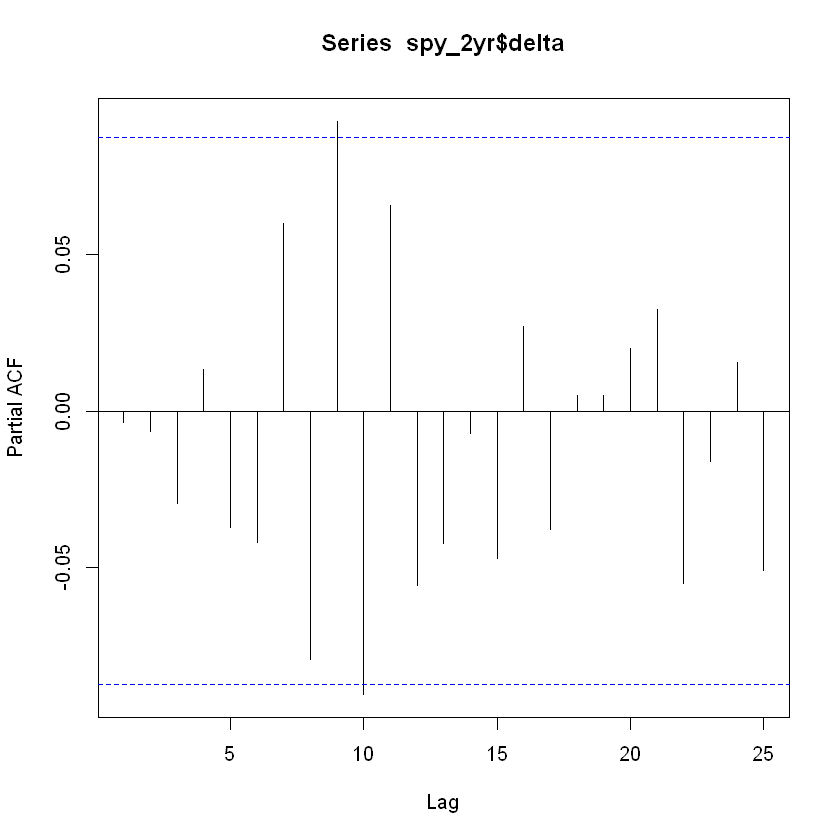

In [13]:
acf(spy_2yr$delta, lag.max = 25, plot = TRUE)
pacf(spy_2yr$delta, lag.max = 25, plot = TRUE)

The ACF plot shows approximately a single statistically significant spike with the rest within threshold limits, while the PACF plot shows two successive spikes that barely exceed threshold limits. These plots do not appear to show conditions that suggest an ARIMA(p, d, 0) model – namely, that the ACF plot shows exponential decay or sinusoidal variation, and the PACF plot shows a significant spike at lag p but none following lag p.

The plots also do not appear to show conditions suggesting an ARIMA(0, d, q) model – specifically, that the PACF plot shows exponential decay or sinusoidal variation, and the ACF plot shows a significant spike at lag q but none following lag q. The PACF plot instead shows inconsistent sinusoidal variation and decay, and the ACF plot shows only one statistically significant spike at lag 0.

## Automatically fitting ARIMA models
We now employ R to automatically fit an ARIMA model to the differenced SPY time series via `auto.arima()`. Since we’re only working with a single time series, we can perform a more exhaustive search to find an optimal ARIMA model by setting stepwise=FALSE and approximation=FALSE.

In [15]:
auto.arima(spy_2yr$delta, seasonal=FALSE, stepwise=FALSE, approximation=FALSE)

Series: spy_2yr$delta 
ARIMA(2,0,2) with zero mean 

Coefficients:
          ar1      ar2     ma1     ma2
      -1.7039  -0.9293  1.6965  0.9513
s.e.   0.0713   0.0613  0.0577  0.0385

sigma^2 = 21.21:  log likelihood = -1480.18
AIC=2970.35   AICc=2970.47   BIC=2991.46

R returns an ARIMA(2, 0, 2) model for the differenced SPY time series, with an AICc of 2970.47. 

For posterity, we employ `auto.arima()` to fit ARIMA models to the non-differenced SPY time series – i.e., simply the daily closing price of SPY over the last two years – and the log-differenced SPY time series, which is obtained by applying the logarithm to the differenced SPY time series. 

For the non-differenced series, R returns an ARIMA(2, 1, 3) model with an AICc of 2966.75.  For the log-differenced series, R returns an ARIMA(2, 0, 2) model with an AICc of -3913.58.  

Of note is that all three ARIMA models are non-seasonal ARIMA models.

An ARIMA model produces cyclical behavior if $ psi1^2 + 4 * psi2^2 < 0 $ , where $psi1$ and $psi2$ are the first two autoregressive coefficients of an ARIMA model with $p >= 2$. We note that this condition is satisfied for the three ARIMA models obtained above via `auto.arima()`. This seems desirable, as SPY and its differenced version also demonstrate cyclical behavior. 

Now armed with what seems to be a sensible ARIMA model for the differenced SPY time series, we check its residuals for white noise to see if the model is suitable for forecasting. `checkresiduals()` produces an ACF plot of residuals, showing all autocorrelations to be within threshold limits:


	Ljung-Box test

data:  Residuals from ARIMA(2,0,2) with zero mean
Q* = 6.6584, df = 6, p-value = 0.3536

Model df: 4.   Total lags used: 10



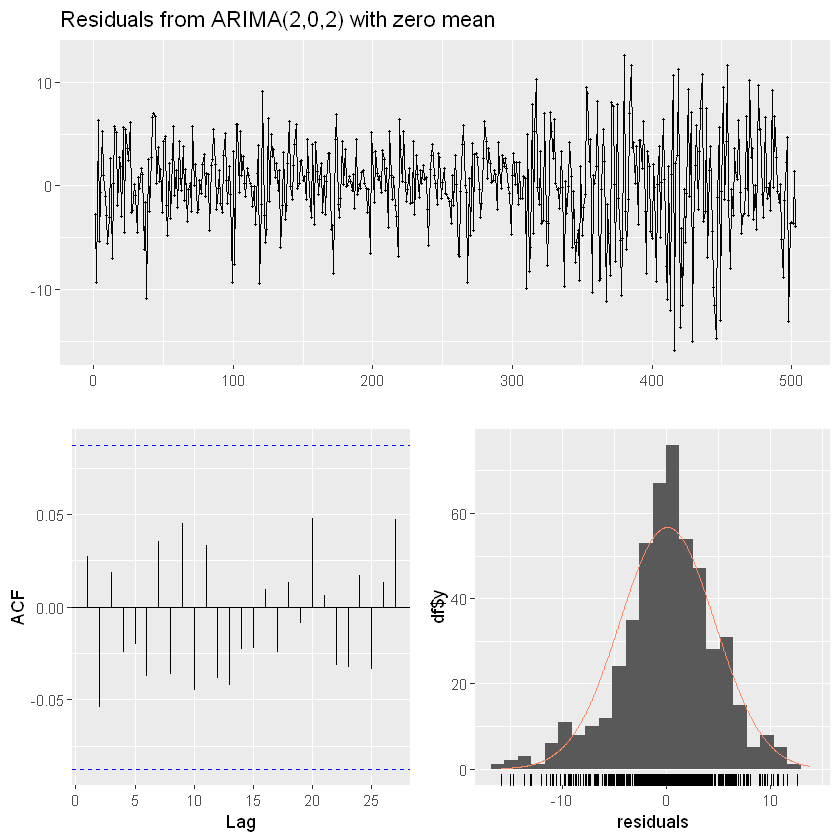

In [17]:
checkresiduals(fit)

A portmanteau test in the form of the Ljung-Box test gives a large p-value (0.3536), and we see the residuals are roughly normally distributed. Accordingly, the residuals of this ARIMA model appear to be white noise, suggesting this model is appropriate for forecasting differenced SPY.

We apply `autoplot(forecast(fit))`, where `fit` is the ARIMA(2, 0, 2) model fit to the differenced SPY time series:

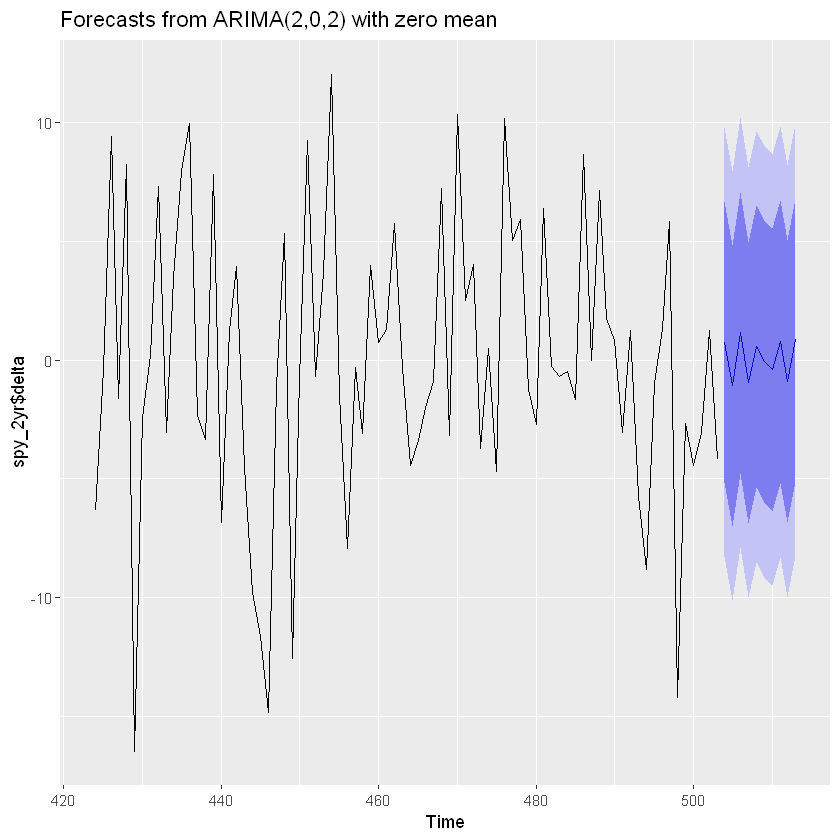

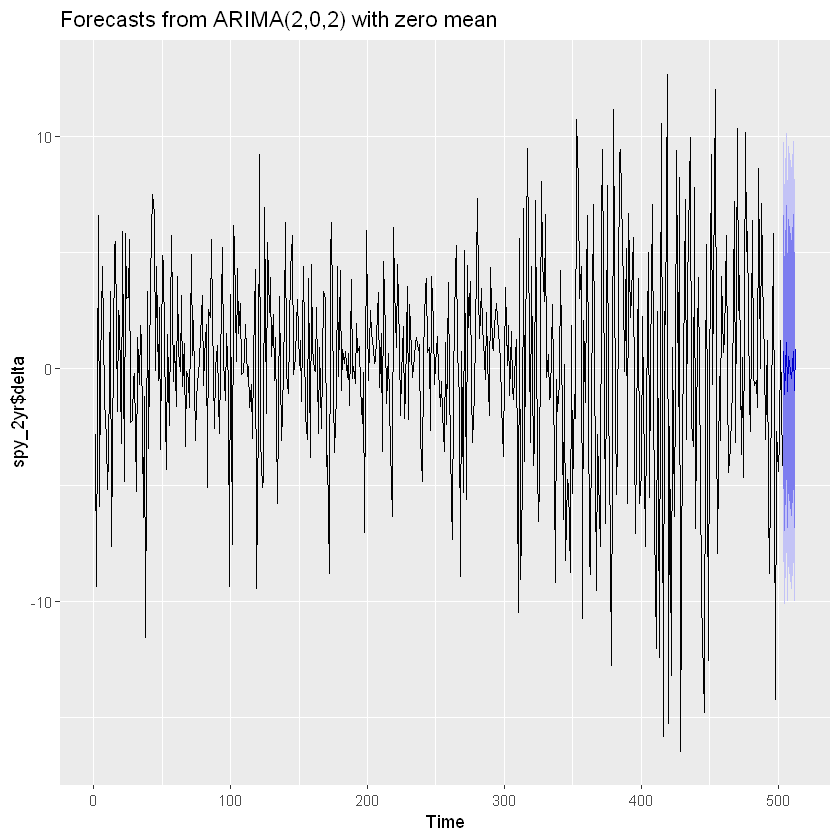

In [20]:
fit %>% forecast(h=10) %>% autoplot(include=80)
autoplot(forecast(fit))

## Limitations and Future Development
An ARIMA(2, 0, 2) model appears to be a reasonably good fit for differenced SPY, and residual examination lends itself to this interpretation. It appears worthwhile to consider the variance of the differenced SPY time series, and of potential note is what seems to be increased variance in the latter portion of the time series. In light of these considerations, logarithmic transformation of the differenced series may help, as may applying a Box-Cox transformation.  

For something closer to production scale or contexts where real assets are used to forecast, an ensemble of models, including non-ARIMA models, would likely outperform any single model, ARIMA or otherwise. Further development should explore other model types, such as seasonal models, as seasonality could be an underlying factor in SPY. 